In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import openpyxl
from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 32  # Set default font size
rcParams['axes.titlesize'] = 24
rcParams['axes.labelsize'] = 24
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 18
rcParams['figure.titlesize'] = 32

In [2]:
FILE_PATH = os.path.join('..', 'raw data', '20250602')
FIGSIZE = (10, 8)
TMP_DIR = "./tmp"

# Ensure temporary directories exist
os.makedirs(TMP_DIR, exist_ok=True)

dir_list = list(filter(lambda x: os.path.isdir(os.path.join(FILE_PATH, x)),
                       os.listdir(FILE_PATH)))
print(pd.DataFrame(dir_list, columns=['Dirs']).head(99))
directory = int(input('choose one directory:'))
FILE_PATH = os.path.join(FILE_PATH, dir_list[directory])
file_list = os.listdir(FILE_PATH)
file_list.sort(key=lambda x: os.path.getmtime(os.path.join(FILE_PATH, x)))
Retention_file_list = list(filter(lambda x: ' Retention' in x, file_list))

FIG_TITLE = FILE_PATH.split('/')[-1].split('(')[0]

                          Dirs
0       STO_1r_0_1_3_Retention
1  STO_1r_0_2_0_1_HRSRetention
2  STO_1r_0_2_0_1_LRSRetention
3          STO_1r_1_0_1_01to30
4          STO_1r_1_0_1_31ot80


choose one directory: 0


In [3]:
df = [[], []]
for index, file in enumerate(Retention_file_list, start=1):
    try:
        curr_df = pd.read_csv(os.path.join(FILE_PATH, file)) if 'csv' in file \
            else pd.read_excel(os.path.join(FILE_PATH, file))
        length = curr_df.shape[0]
        df[0].extend(curr_df['MeasResult1_value'].values)
        df[1].extend(curr_df['MeasResult2_value'].values)
    except pd.errors.EmptyDataError:
        print(file)
df = pd.DataFrame(np.transpose(df), columns=['Vd (V)', 'Id (A)'])
df['Vd (V)'] = pd.to_numeric(df['Vd (V)'])
df['Id (A)'] = pd.to_numeric(df['Id (A)'], errors='coerce')
df['abs(Id)'] = abs(df['Id (A)'])
df['Resistance (Ohm)'] = \
    abs(df['Vd (V)'] / df['Id (A)']).where(df['Vd (V)'] != 0)

6_3_2025 9_03_03 PM  [STO_1r_0_1_3(8) Retention; ].csv


In [4]:
print(FILE_PATH)
print(FIG_TITLE)

../raw data/20250602/STO_1r_0_1_3_Retention
STO_1r_0_1_3_Retention


6_3_2025 9_03_03 PM  [STO_1r_0_1_3(8) Retention; ].csv


/tmp/ipykernel_245472/1832222676.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


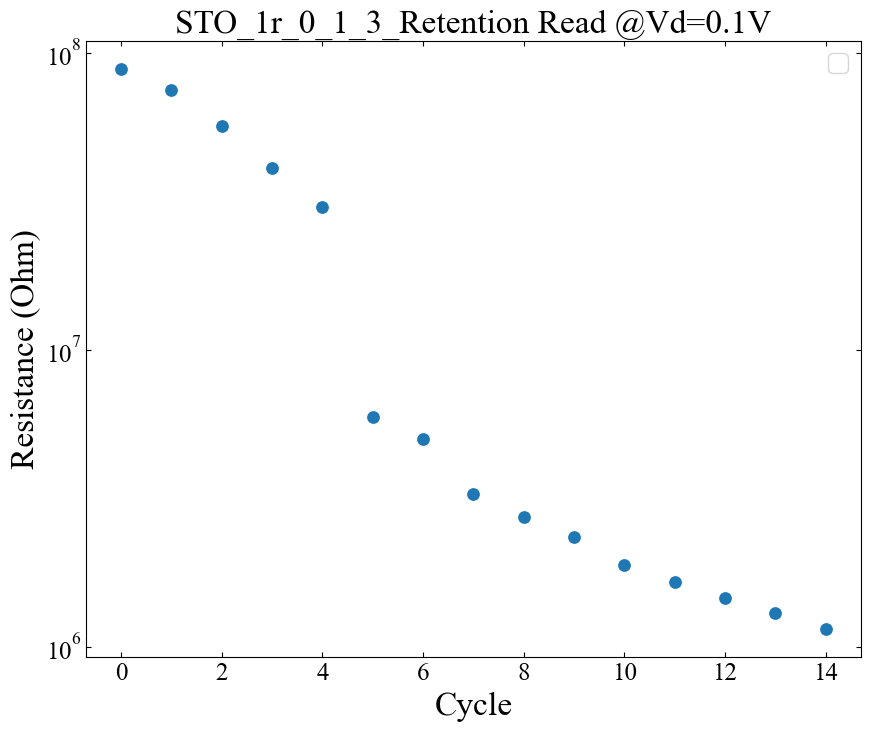

In [5]:
def load_single_file(file: str) -> pd.DataFrame:
    """
    Loads a single file (CSV or Excel) and returns its contents as a DataFrame.
    """
    file_full = os.path.join(FILE_PATH, file)
    try:
        if "csv" in file.lower():
            return pd.read_csv(file_full)
        else:
            return pd.read_excel(file_full)
    except pd.errors.EmptyDataError:
        raise


def extract_measurement(df: pd.DataFrame) -> list:
    """
    Extracts measurement values from a DataFrame.
    Returns a list containing the absolute values of Id and Vd from the second row.
    """
    try:
        # Use .iloc[1] for clarity; you might want to add checks if the DataFrame is empty
        return [abs(df['MeasResult1_value'].mean()), abs(df['MeasResult2_value'].mean())]
    except (IndexError, KeyError) as e:
        print("Error extracting measurement:", e)
        print(df)
        return None


def process_file_group(file_list: list) -> pd.DataFrame:
    """
    Process a list of files into a DataFrame containing 'Id' and 'Vd' columns.
    Also computes resistance as Vd/Id.
    """
    measurements = []
    for file in file_list:
        try:
            df_file = load_single_file(file)
            meas = extract_measurement(df_file)
            if meas is not None:
                measurements.append(meas)
        except pd.errors.EmptyDataError:
            print(file)
    if len(measurements) == 0:
        df_result = pd.DataFrame(columns=["Vd (V)", "Id (A)"])
        return df_result
    df_result = pd.DataFrame(np.array(measurements), columns=["Vd (V)", "Id (A)"])
    df_result["Resistance (Ohm)"] = df_result["Vd (V)"] / df_result["Id (A)"]
    return df_result


def process_read_files_MIM(Retention_file_list: list) -> list:
    """
    Processes files from a given list for two groups (read1/HRS and read2/LRS).
    Returns a list with two DataFrames: [HRS, LRS].
    """

    df_retention = process_file_group(Retention_file_list)

    # Plot the combined read data
    plot_read_data(df_retention)

    return df_retention


def plot_read_data(df: pd.DataFrame):
    """
    Plots the resistance for the two sets of read data.
    """
    fig, ax = plt.subplots(figsize=FIGSIZE)
    # title = f"{FIG_TITLE} Read @Vd={df1.loc[0, 'Vd']}V"
    title = f"{FIG_TITLE} Read @Vd=0.1V"
    ax.set(title=title, xlabel="Cycle", ylabel="Resistance (Ohm)", yscale="log")
    sns.scatterplot(x=df.index, y=df["Resistance (Ohm)"], ax=ax, markers="o", s=100)
    ax.tick_params(axis='both', which='major', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='minor', bottom=False, top=False, left=False, right=False)
    plt.legend()
    output_file = os.path.join(TMP_DIR, f"{FIG_TITLE}_read_a.png")
    plt.savefig(output_file)
    plt.show()


retention_df = process_read_files_MIM(Retention_file_list)

In [6]:
def export_for_origin(retention_df: pd.DataFrame):
    """
    Exports the provided data frames to an Excel file for Origin.
    """
    # Create a excel file for origin
    output_file = os.path.join(FILE_PATH, "for_origin.xlsx")
    empty_df = pd.DataFrame()
    empty_df.to_excel(output_file)
    print("Exporting to:", output_file)

    with pd.ExcelWriter(output_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        retention_df.to_excel(writer, sheet_name=FIG_TITLE, index=False)


export_for_origin(retention_df)

Exporting to: ../raw data/20250602/STO_1r_0_1_3_Retention/for_origin.xlsx
